# L3: Text clustering and topic modelling

Text clustering groups documents in such a way that documents within a group are more &lsquo;similar&rsquo; to other documents in the cluster than to documents not in the cluster. The exact definition of what &lsquo;similar&rsquo; means in this context varies across applications and clustering algorithms.

In this lab you will experiment with both hard and soft clustering techniques. More specifically, in the first part you will be using the $k$-means algorithm, and in the second part you will be using a topic model based on the Latent Dirichlet Allocation (LDA).

**A quick reminder about our [Rules for hand-in assignments](https://www.ida.liu.se/~TDDE16/exam.en.shtml#handins) and the [Policy on cheating and plagiarism](https://www.ida.liu.se/~TDDE16/exam.en.shtml#cheating)**

## Hard clustering data set

The raw data for the hard clustering part of this lab is a collection of product reviews. We have preprocessed the data by tokenization and lowercasing.

In [5]:
import pandas as pd
import bz2

with bz2.open('reviews.json.bz2') as source:
    df = pd.read_json(source)

When you inspect the data frame, you can see that there are three labelled columns: `category` (the product category), `sentiment` (whether the product review was classified as &lsquo;positive&rsquo; or &lsquo;negative&rsquo; towards the product), and `text` (the space-separated text of the review).

In [6]:
df.head()

,category,sentiment,text
0,music,neg,i bought this album because i loved the title ...
1,music,neg,i was misled and thought i was buying the enti...
2,books,neg,"i have introduced many of my ell , high school..."
3,books,pos,anything you purchase in the left behind serie...
4,dvd,pos,"i loved these movies , and i cant wiat for the..."


## Problem 1: K-means clustering

Your first task is to cluster the product review data using a tf–idf vectorizer and a $k$-means clusterer.

Start by doing the vectorization. In connection with vectorization, you should also filter out standard English stop words. While you could use [spaCy](https://spacy.io/) for this task, here it suffices to use the word list implemented in [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html).

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer



vectorizer = TfidfVectorizer(stop_words='english')
reviews = vectorizer.fit_transform(df['text'])

Test your vectorization by running the following code cell:

In [8]:
reviews.shape

(11914, 46619)

If you used the English stop word list from scikit-learn, then the resulting vocabulary should have 46,619 entries.

Next, cluster the vectorized data. Before doing so, you should read the documentation of the [KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) class, which is scikit-learn&rsquo;s implementation of the $k$-means algorithm. As you can see, this class has several parameters that you can tweak. For now, the only parameter that you will have to set is the number of clusters. Start with $k=3$.

**Tip:** Training $k$-means models will take some time. To speed things up, you can use the `n_init` parameter to control the number of times that the clustering is re-computed with different initial values. The default value for this parameter is 10; here and in the rest of this lab, you may want to set this to a lower value.

In [9]:
from sklearn.cluster import KMeans
import numpy as np

kmeans = KMeans(n_clusters=3, n_init=10).fit(reviews)
kmeans_predict = kmeans.predict(reviews)
print(kmeans_predict.shape)

(11914,)


To sanity-check your clustering, create a bar plot with the number of documents per cluster.

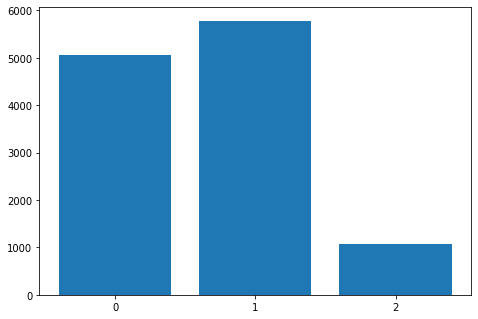

In [10]:
import matplotlib.pyplot as plt

unique, counts = np.unique(kmeans_predict, return_counts=True)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
clusters = ['0','1','2']
docs = dict(zip(unique, counts)).values()
ax.bar(clusters,docs)
plt.show()

Note that sizes may vary considerable between clusters and among different random seeds.

## Problem 2: Summarize clusters

Once you have a clustering, you can try to see whether it is meaningful. One useful technique in that context is to generate a **summary** for each cluster by extracting the $n$ highest-weighted terms from the centroid of each cluster. Your next task is to implement this approach.

**Hint:** You will need to construct an &lsquo;inverted vocabulary&rsquo; that allows you to map from the index of a term back to the original term.

In [11]:
centroids = kmeans.cluster_centers_.argsort()[:,::-1]
names = vectorizer.get_feature_names_out()

for i in range(3):
    print("cluster: " , i)
    for indexes in centroids[i,:10]:
        print(names[indexes], end='  ')
    print('\n')


cluster:  0
product  use  software  does  great  program  used  just  work  time  

cluster:  1
book  movie  album  like  cd  just  music  quot  great  good  

cluster:  2
camera  lens  pictures  canon  digital  use  flash  battery  quality  great  



Once you have computed the cluster summaries, take a minute to reflect on their quality. Is it clear what the reviews in a given cluster are about? Do the cluster summaries contain any unexpected terms?

All the categories are clear, with them being software, books and then cameras. 

## Problem 3: Compare clusterings using the Rand index

In some scenarios, you may have gold-standard class labels available for at least a subset of your documents. In these cases you can compute the **Rand index** of a clustering, and use this measure to compare the quality of different clusterings.

To compute the Rand index, we view a clustering as a binary classifier on (unordered) pairs of documents. The classifier predicts &lsquo;positive&rsquo; if and only if the two documents belong to the same cluster. The (non-normalized) Rand index of the clustering is the accuracy of this classifier relative to a reference in which a document pair belongs to the &lsquo;positive&rsquo; class if and only if the two documents in the pair have the same gold-standard class label. You are supposed to implement the procedure yourselves, not import an external function.

Compare clusterings with $k \in \{1,3,5,7\}$ clusters. As your evaluation data, use the first 500 documents from the original data set along with their gold-standard categories (from the `category` column).

In [14]:
clusters = [1,3,5,7]
data = df.head(500)
reviews = vectorizer.fit_transform(data['text'])



for cluster in [1, 3, 5, 7]:
    correct_array = []
    kmeans = KMeans(n_clusters=cluster, n_init=10).fit(reviews)
    kmeans_predict = kmeans.predict(reviews)[:500]
    
    for i in range(0,500):
        for j in range(i+1,500):
            if((kmeans_predict[i]==kmeans_predict[j]) and (data['category'][i]==data['category'][j])):
                correct_array.append(1)
            elif((kmeans_predict[i]!=kmeans_predict[j]) and (data['category'][i]!=data['category'][j])):
                correct_array.append(1)
            else:
                correct_array.append(0)
    print('Cluster: ',cluster,' Acc: ',sum(correct_array)/len(correct_array))



Cluster:  1  Acc:  0.16626052104208416
Cluster:  3  Acc:  0.5363527054108217
Cluster:  5  Acc:  0.8285851703406814
Cluster:  7  Acc:  0.8261723446893787


We see that the accuracy for 1 cluster is very low, and that the highest rand index is with 5 clusters, which is in this case optimal and should be chosen

## Topic modelling data set

The data set for the topic modelling part of this lab is the collection of all [State of the Union](https://en.wikipedia.org/wiki/State_of_the_Union) addresses from the years 1975–2000. These speeches come as a single text file with one sentence per line. The following code cell prints the first 5 lines from the data file:

In [62]:
with open('sotu_1975_2000.txt') as source:
    for i, line in enumerate(source):
        print(line.rstrip())
        if i >= 5:
            break

mr speaker mr vice president members of the 94th congress and distinguished guests
twenty six years ago a freshman congressman a young fellow with lots of idealism who was out to change the world stood before sam rayburn in the well of the house and solemnly swore to the same oath that all of you took yesterday an unforgettable experience and i congratulate you all
two days later that same freshman stood at the back of this great chamber over there someplace as president truman all charged up by his single handed election victory reported as the constitution requires on the state of the union
when the bipartisan applause stopped president truman said i am happy to report to this 81st congress that the state of the union is good our nation is better able than ever before to meet the needs of the american people and to give them their fair chance in the pursuit of happiness it is foremost among the nations of the world in the search for peace
today that freshman member from michigan stan

Take a few minutes to think about what topics you would expect in this data set.

## Problem 4: Train a topic model

Your first task on the topic modelling data is to train an LDA model. For this task you will be using [spaCy](https://spacy.io/) and the [gensim](https://radimrehurek.com/gensim/) topic modelling library.

Start by preprocessing the data using spaCy. Given that the data set for this problem is rather small, you do not have to exclude any components from the standard pipeline. Filter out stop words, non-alphabetic tokens, and tokens less than 3 characters in length. Store the documents as a nested list where the first level of nesting corresponds to the sentences and the second level corresponds to the tokens in each sentence.

In [14]:
# TODO: Replace the following lines with your own code for preprocessing the documents
import spacy
nlp = spacy.load("en_core_web_sm")

def preprocess(doc):
    to_process = nlp(doc)
    output = []
    for token in to_process:
        if(not token.is_stop and token.lemma_.isalpha() and len(token)>2):
            output.append(token.lemma_)
    return output
with open('sotu_1975_2000.txt') as source:
    documents = [line.split() for line in source]
    processed_documents = []
    for sent in documents:
        processed_documents.append(preprocess(str(sent)))

Test your preprocessing by running the following cell:

In [15]:
' '.join(processed_documents[42])

'reduce oil import million barrel day end year million barrel day end'

You should get the following output:

Once you have the list of documents, skim the section [Pre-process and vectorize the documents](https://radimrehurek.com/gensim/auto_examples/tutorials/run_lda.html#pre-process-and-vectorize-the-documents) of the gensim documentation to learn how to create the dictionary and the vectorized corpus representation required by gensim. (Note that you cannot use the standard scikit-learn pipeline in this case.) Then, write code to train an [LdaModel](https://radimrehurek.com/gensim/models/ldamodel.html) for $k=10$ topics, and using default values for all other parameters.

In [18]:
from gensim.corpora import Dictionary

dictionary = Dictionary(processed_documents)
dictionary.filter_extremes(no_below=20, no_above=0.5)
corpus = [dictionary.doc2bow(doc) for doc in processed_documents]

from gensim.models import LdaModel


num_topics = 10
temp = dictionary[0]
id2word = dictionary.id2token

model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    num_topics=num_topics,
)

Once you have a trained model, run the following cell to print the topics:

In [19]:
model.print_topics()

[(0,
  '0.025*"america" + 0.022*"new" + 0.018*"people" + 0.015*"year" + 0.013*"opportunity" + 0.013*"american" + 0.012*"nation" + 0.011*"proud" + 0.011*"americans" + 0.011*"life"'),
 (1,
  '0.023*"year" + 0.018*"world" + 0.016*"people" + 0.014*"challenge" + 0.013*"let" + 0.013*"america" + 0.012*"tonight" + 0.011*"congress" + 0.010*"action" + 0.009*"government"'),
 (2,
  '0.018*"know" + 0.017*"people" + 0.017*"work" + 0.015*"year" + 0.013*"help" + 0.013*"child" + 0.013*"government" + 0.012*"let" + 0.011*"crime" + 0.011*"need"'),
 (3,
  '0.025*"child" + 0.019*"america" + 0.016*"year" + 0.014*"thank" + 0.012*"world" + 0.012*"american" + 0.011*"nation" + 0.011*"new" + 0.010*"ask" + 0.010*"begin"'),
 (4,
  '0.029*"year" + 0.019*"cut" + 0.018*"budget" + 0.011*"america" + 0.011*"new" + 0.010*"tax" + 0.009*"increase" + 0.009*"congress" + 0.009*"deficit" + 0.009*"percent"'),
 (5,
  '0.025*"child" + 0.023*"state" + 0.022*"year" + 0.017*"work" + 0.016*"country" + 0.014*"parent" + 0.014*"support" 

Inspect the topics. Can you &lsquo;label&rsquo; each topic with a short description of what it is about? Do the topics match your expectations?

> **Answer:** each time it is run there are different topics. But generally there is a way to identify the different topics to some extent. For example:

> > care health job work year family people ask need business

> This topic would most likely be about "health-care" in the context of job/work/business. some words provide little meaning here, like the word 'year' which appear basically everywhere. Since the dataset is on a kind of new year speech, 'year' is a domain specific stop word that can be ignored. 

> Other roughly identified topics are: "American national federal program", "Cut taxes for school", "Drug use report", "Peace and national security", "Something about good congress action?", "Unclear, year highly weighted", "Something about children this century", "Help children stay in school so they can work?"

> It is not always clear what the topic is about, but many of them seem to be about the expected topics of economy, education, children, etc.

## Problem 5: Monitor a topic model for convergence

When learning an LDA model, it is important to make sure that the training algorithm has converged to a stable posterior distribution. One way to do so is to plot, after each training epochs (or &lsquo;pass&rsquo;, in gensim parlance) the log likelihood of the training data under the posterior. Your last task in this lab is to create such a plot and, based on this, to suggest an appropriate number of epochs.

To collect information about the posterior likelihood after each pass, we need to enable the logging facilities of gensim. Once this is done, gensim will add various diagnostics to a log file `gensim.log`.

In [20]:
import logging

logging.basicConfig(filename='gensim.log', format='%(asctime)s:%(levelname)s:%(message)s', level=logging.INFO)

The following function will parse the generated logfile and return the list of log likelihoods.

In [21]:
import re

def parse_logfile():
    matcher = re.compile('(-*\d+\.\d+) per-word .* (\d+\.\d+) perplexity')
    likelihoods = []
    with open('gensim.log') as source:
        for line in source:
            match = matcher.search(line)
            if match:
                likelihoods.append(float(match.group(1)))
    return likelihoods

Your task now is to re-train your LDA model for 50&nbsp;passes, retrieve the list of log likelihoods, and create a plot from this data.

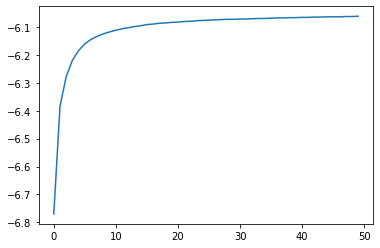

In [22]:
model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    num_topics=num_topics,
    passes=50,
)
log = parse_logfile()
plt.plot(log)

How do you interpret your plot? Based on the plot, what would be a reasonable choice for the number of passes? Retrain your LDA model with that number and re-inspect the topics it finds. Do you consider the new topics to be &lsquo;better&rsquo; than the ones that you got from the 1-pass model in Problem&nbsp;4?

The increase in performance stagnates at about 30 passes, and thus we chose 30 for the amount of passes. We find the topics better and easier to understand now.

In [23]:
model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    num_topics=num_topics,
    passes=30,
)
model.print_topics()

[(0,
  '0.024*"world" + 0.023*"nation" + 0.022*"peace" + 0.018*"state" + 0.017*"nuclear" + 0.016*"united" + 0.015*"continue" + 0.015*"soviet" + 0.015*"force" + 0.015*"war"'),
 (1,
  '0.043*"welfare" + 0.043*"president" + 0.035*"work" + 0.027*"congress" + 0.021*"year" + 0.019*"people" + 0.017*"know" + 0.017*"house" + 0.017*"want" + 0.016*"system"'),
 (2,
  '0.047*"new" + 0.043*"job" + 0.031*"help" + 0.031*"community" + 0.023*"work" + 0.022*"business" + 0.020*"private" + 0.020*"woman" + 0.017*"create" + 0.015*"year"'),
 (3,
  '0.069*"child" + 0.063*"school" + 0.036*"parent" + 0.025*"thank" + 0.023*"education" + 0.021*"year" + 0.021*"help" + 0.020*"teacher" + 0.019*"good" + 0.018*"drug"'),
 (4,
  '0.046*"health" + 0.044*"care" + 0.039*"family" + 0.031*"work" + 0.020*"pay" + 0.020*"million" + 0.019*"child" + 0.018*"people" + 0.018*"year" + 0.017*"americans"'),
 (5,
  '0.033*"people" + 0.027*"america" + 0.026*"year" + 0.021*"work" + 0.018*"americans" + 0.016*"know" + 0.015*"new" + 0.014*"am

## Reflection questions

The following reflection questions are questions that you could be asked in the oral exam. Try to answer each of them in the form of a short text and enter it in the cell below. You will get feedback on your answers from your lab assistant.

**RQ 3.1:** Based on your experiments in Problem&nbsp;2 and Problem&nbsp;3, what is the relation between the quality of a clustering and the number of clusters? What happens when the number of clusters is too low, or too high? For this particular data set, what would a &lsquo;good&rsquo; number of clusters be?
> As we saw earlier in the lab, a good amount of clusters for this lab was found to be 5. If too few clusters are used then several groups of data which are not connected will be forced into one large cluster. If too many clusters are used then groups which are connected in reality are split into more artificial clusters which worsens the quality and accuracy of the model.

**RQ 3.2:** Explain why it is important to monitor an LDA model for convergence and not simply use, say, 1000&nbsp;passes. How is the log likelihood used in this context? Were the topics from the multi-pass model &lsquo;better&rsquo; than the topics from the 1-pass model?

> In order to avoid overfitting, the number of passes should be stopped when the graph converges. in this context, the log likelihood is used for each training pass to get an understanding of how much change the passes bring relative to eachother. The plot indicates that the number of passes should be at the very least more than 5 for a good score, but after that the changes are quite slow. Somewhere between 20 and 30 the changes become relatively insignificant, for this example, which means that it has converged and should be stopped.  

> The topics from the multi-pass model are much simpler to identify, having many more relevant terms for every topic, making it more straightforward and less ambiguous. There where however a few "junk topics" which basically consists of the domain specific stop words here, but they were also easy to identify and can thus simply be excluded when analysing the topics. 

**RQ 3.3:** What are the differences between $k$-means and LDA? When would you use one, when the other?

> K-means is a so called "hard clustering" model and LDA is a "soft clustering" model. Hard clustering is binary in the sense that a data point either belong completely to a cluster, or not. Soft clustering on the other hand have its data points belonging to all clusters with a certain probability.

> The hard clustering is fast and excellent when there is a need to classify documents to very specific classes, like for example: when determining if a review is positive or negative. 
Soft clustering, on the other hand, is great when the relevant classes are somewhat fussy and a document can belong to many at the same time, to a certain degree. For the topic identifier used in problem 4 and 5, this would be the more appropriate model. However, soft clustering is slower as there are more values to compute and as a result, it takes longer for the algorithms to converge.

*TODO: Enter your answers here*

**Congratulations on finishing L3! 👍**